Explain this better.

In [1]:
import os.path
from scipy import *
import numpy as np
from numpy import *
from numpy import linalg as LA
from scipy import linalg as LA2
import sympy as sympy
import sys as sys
from fractions import Fraction
import time
import matplotlib.pyplot as plt
import itertools as it
from IPython.core.display import HTML

sys.path.append('/Users/sashacurcic/SashasDirectory/ANAG/FV_MG/')
from Modules import BasicTools as BT
from Modules import WaveTools as WT
from Modules import PlotTools as PT
from Modules import FFTTools as FFTT
from Modules import OperatorTools as OT
from Modules import GridTransferTools as GTT
from Modules import TestTools as TT
from Modules import SolverTools as ST
from Modules import WaveformTools as WFT

display(HTML("<style>pre { white-space: pre !important; }</style>"))
np.set_printoptions( linewidth = 10000, threshold = 100000)

In [2]:
nh = 32
refRatio = 2
c = 1.
CFL = 0.5
nt = 4
mode = 5
Hans = False

L = 1
locs = []#x_1]
epsilons = [1]#0.5, 0.5] # [1, 1]
mus = [1]#0.5, 0.5] # [1, 1]

func = WFT.Gauss

In [3]:
omegaAMR = BT.Grid(nh)
finehalf = list(np.arange(int(nh / refRatio)))# + int(nh / refRatio))
omegaAMR.AddPatch(refRatio, finehalf)
degFreed = omegaAMR.degFreed
nh_min = omegaAMR.nh_min
nh_max = omegaAMR.nh_max
t, nt = ST.CalcTime(omegaAMR, CFL, c, nt = nt)
mu, sigma = WFT.GaussParams(0, 0.5)
args = [mu, sigma]

wavesAMR = WT.MakeWaves(omegaAMR)
nullspace = OT.FindNullspace(omegaAMR, wavesAMR, Hans = Hans)
restrictOp = GTT.CoarsenOp(omegaAMR)

omegaF = BT.Grid(nh_max)
wavesF = WT.MakeWaves(omegaF)
omegaC = BT.Grid(nh_min)
wavesC = WT.MakeWaves(omegaC)

derivMatAMR = TT.ExactSpatOp(omegaAMR)
spatOp = -c * derivMatAMR
timePropOp = LA2.expm(t * spatOp)

derivMatC = TT.ExactSpatOp(omegaC)
spatOpC = -c * derivMatC
timePropOpC = LA2.expm(t * spatOpC)

You are using ExactSpatOp in TestTools module!
You are using ExactSpatOp in TestTools module!


In [4]:

physicsAMR = BT.PhysProps(omegaAMR, epsilons, mus, locs, L)
cAMR = physicsAMR.cVec
cMatAMR = physicsAMR.cMat

physicsC = BT.PhysProps(omegaC, epsilons, mus, locs, L)
cC = physicsC.cVec
cMatC = physicsC.cMat

physicsF = BT.PhysProps(omegaF, epsilons, mus, locs, L)
cF = physicsF.cVec
cMatF = physicsF.cMat

c = cC[0]

initial AMR:
[ 7.80446402e-02  1.53131573e-01 -0.00000000e+00  0.00000000e+00 -1.44587914e-01 -1.31393012e-01 -0.00000000e+00  0.00000000e+00  1.14922486e-01  9.67459244e-02 -0.00000000e+00  0.00000000e+00 -7.83804864e-02 -6.11104149e-02 -0.00000000e+00  0.00000000e+00  4.58646858e-02  3.31426414e-02 -0.00000000e+00 -0.00000000e+00 -2.30393056e-02 -1.53888548e-02 -0.00000000e+00 -0.00000000e+00  9.90726951e-03  6.20222242e-03 -0.00000000e+00  0.00000000e+00 -3.71919928e-03 -1.82124953e-03 -0.00000000e+00  0.00000000e+00  1.59912425e-03  0.00000000e+00  7.05126280e-07  1.00000000e-14  0.00000000e+00 -2.92345593e-06 -2.05372163e-04 -0.00000000e+00 -0.00000000e+00  4.95985373e-04 -4.44097430e-05 -0.00000000e+00  0.00000000e+00 -6.98946624e-06 -5.47962128e-05  0.00000000e+00]
[ 7.80446402e-02  1.50188489e-01 -2.98743479e-02 -5.53313490e-02 -1.33581693e-01 -1.09251178e-01  7.29993030e-02  8.12628666e-02  8.12628666e-02  5.37468095e-02 -8.04377848e-02 -7.24126816e-02 -2.99943148e-02 -1.19233

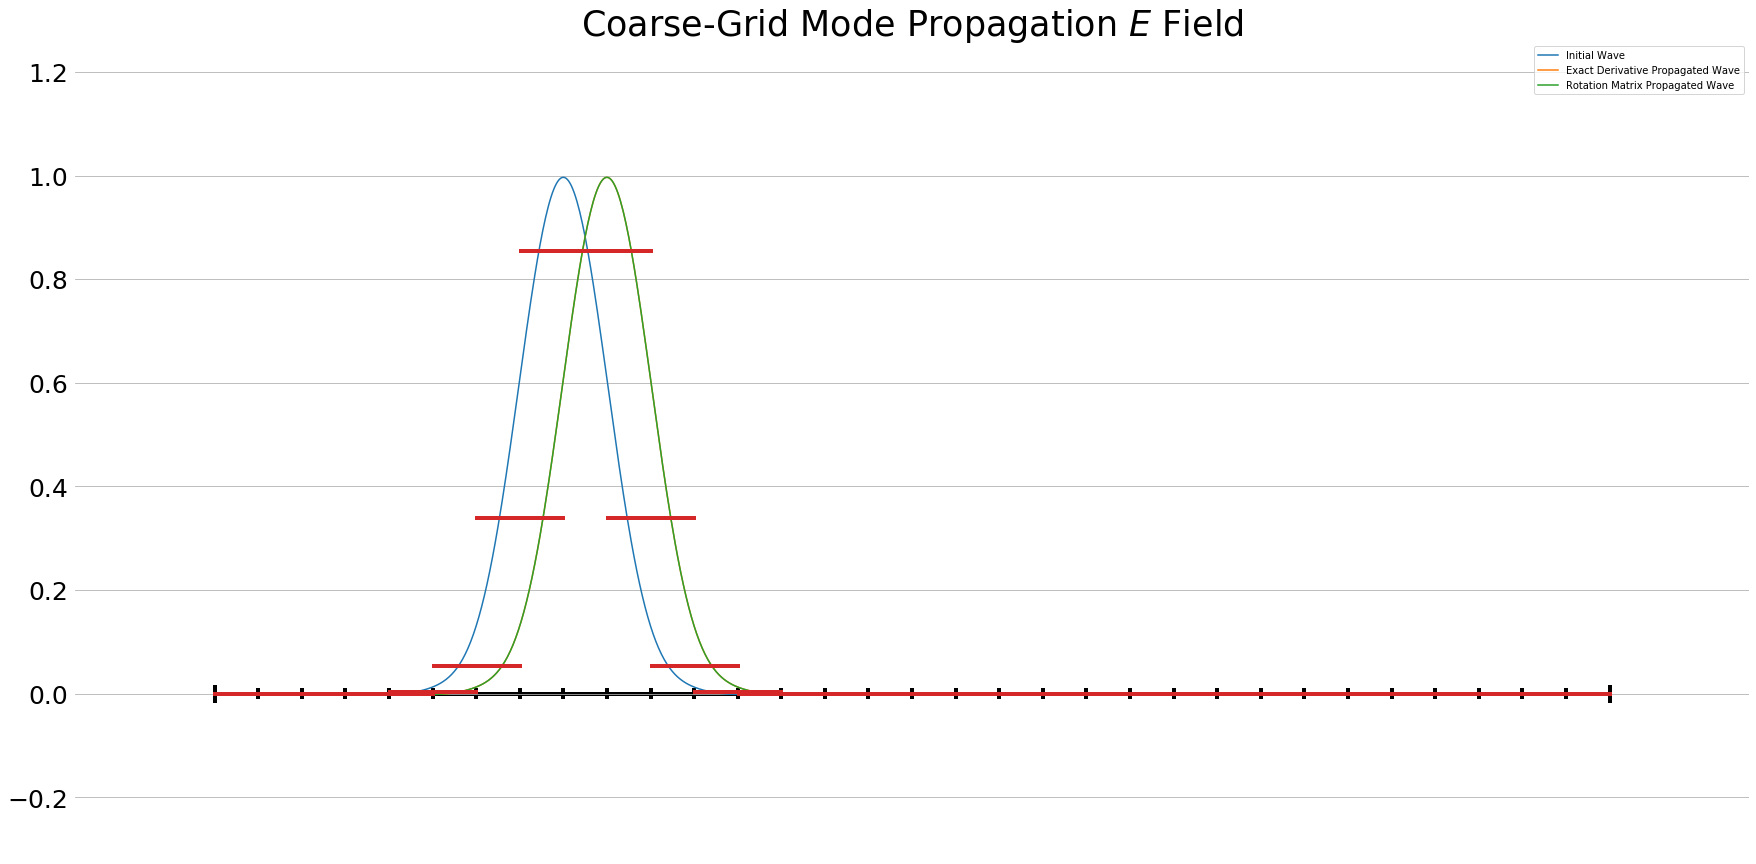

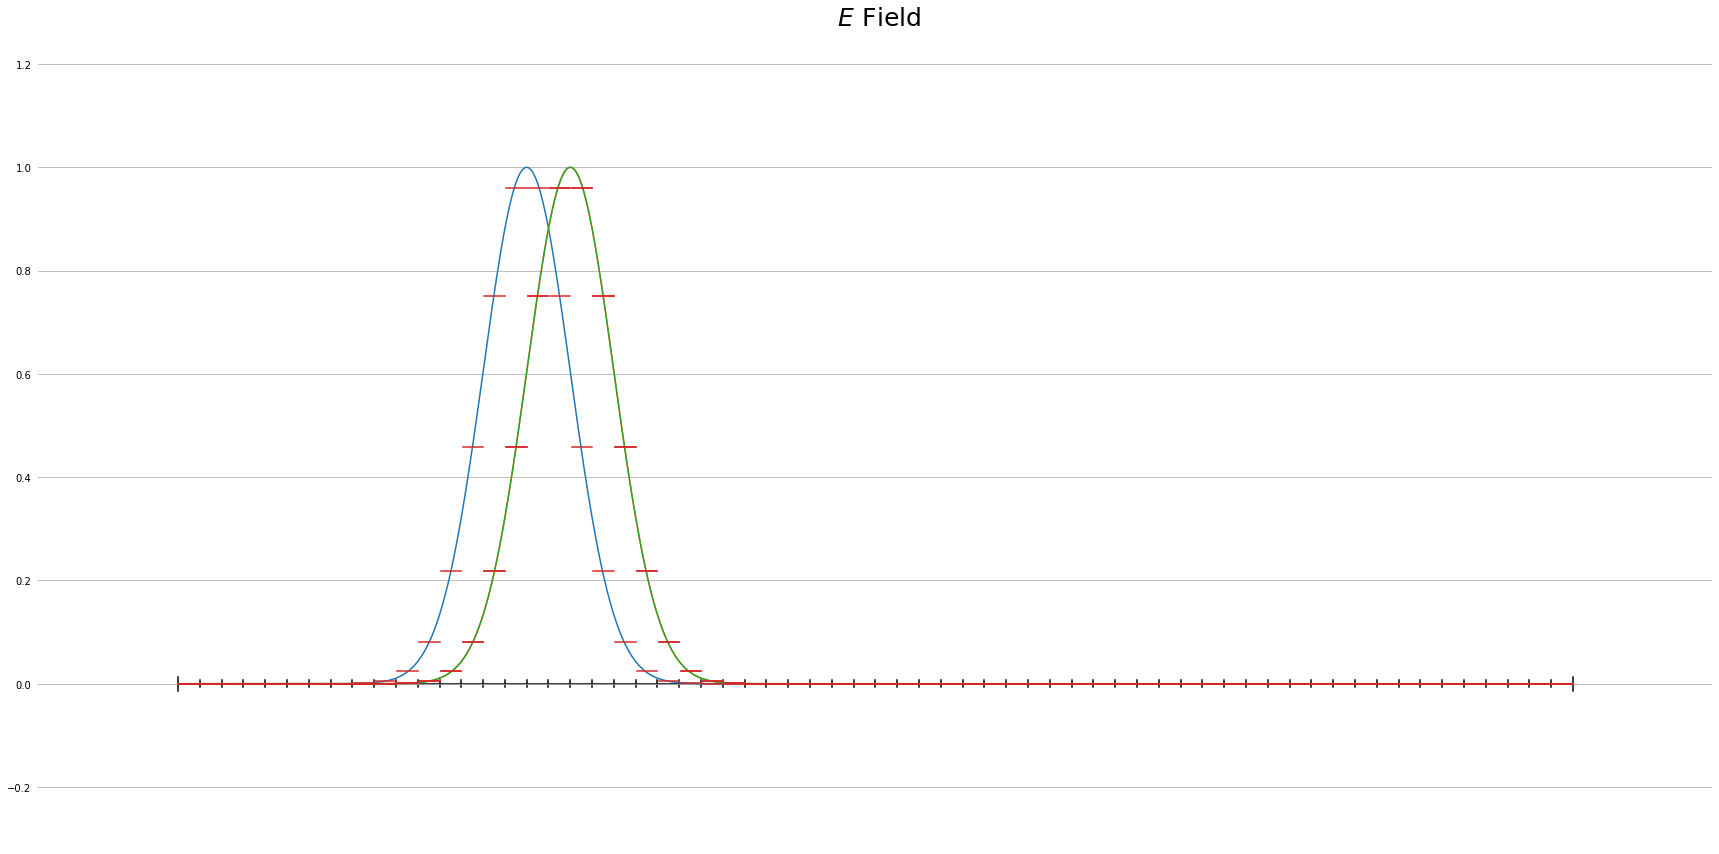

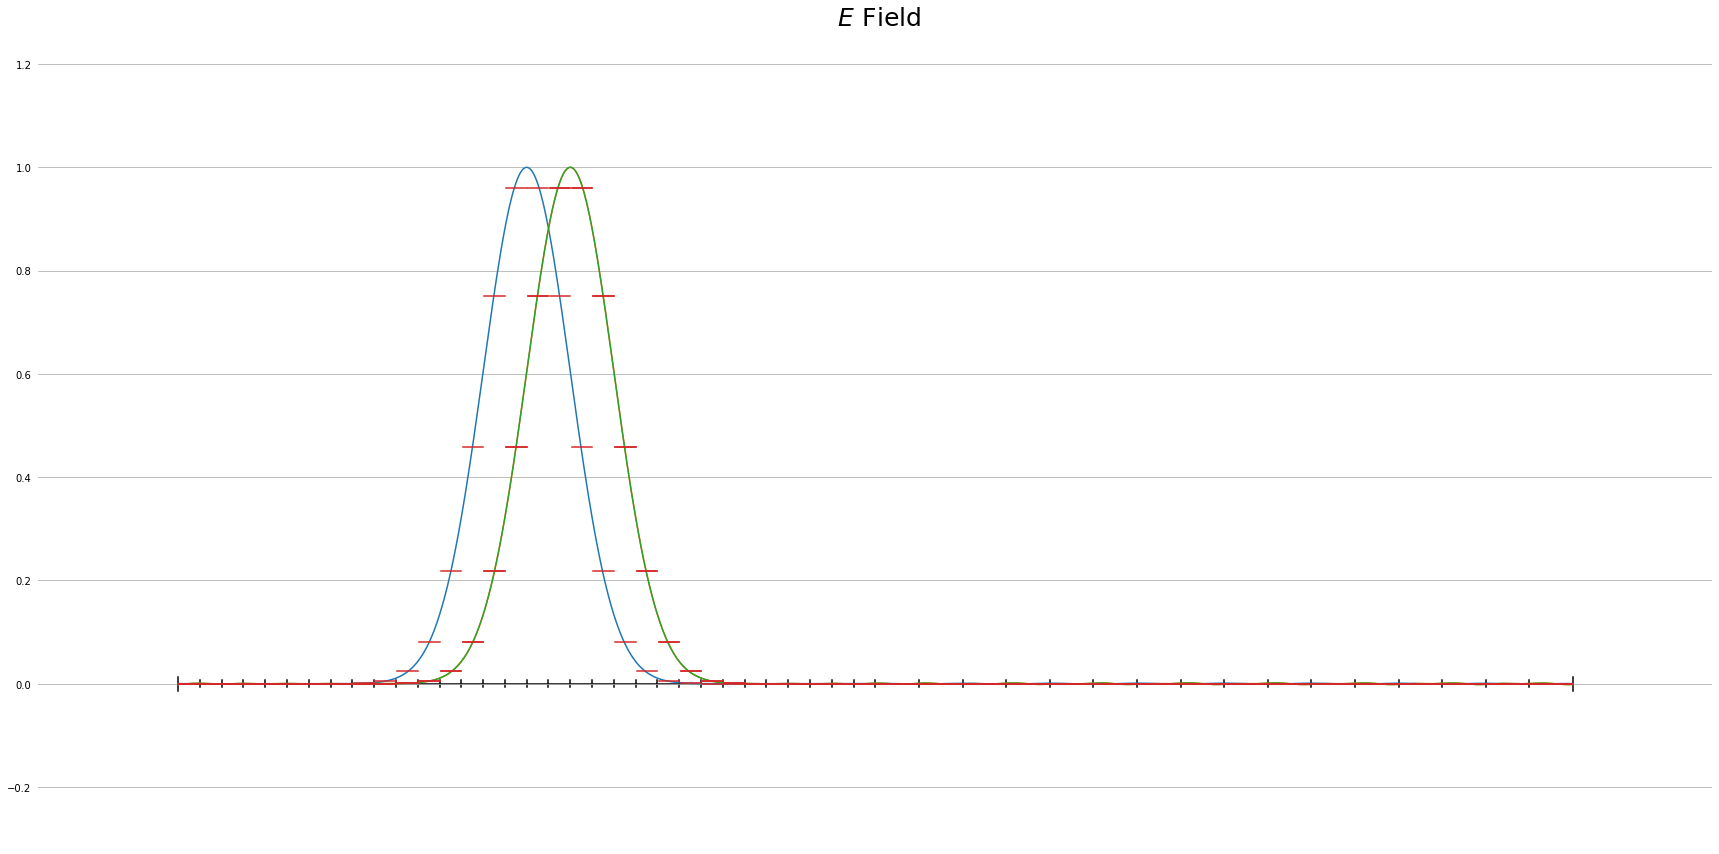

In [6]:
# Initiate Fourier coefficients for initial condition on coarse and fine grids.
# FCoefsF = np.zeros(nh_max, float)
# FCoefsF[mode - 1] = 1
# print(FCoefsF)
# FCoefsC = np.zeros(nh_min, float)
# if (mode <= nh_min):
#     FCoefsC[mode] = 1
# else:
#     kAct = np.ceil(mode / 2.)
#     kAlias = nh_min - kAct
#     index = int((2 * kAlias) + (mode % 2) + 1)
#     print(mode, kAct, kAlias, index)
#     FCoefsC[index] = 1

# # Find initial waveform on coarse, fine, and AMR grids.
# waveInitC = wavesC @ FCoefsC
# waveInitF = wavesF @ FCoefsF
# waveInitAMR = restrictOp @ waveInitF


waveInitC = WFT.InitCond(omegaC, physicsC, func, args)
# waveInitC = np.append(waveInitC, waveInitC)
waveInitF = WFT.InitCond(omegaF, physicsF, func, args)
waveInitAMR = WFT.InitCond(omegaAMR, physicsAMR, func, args)

FCoefsC = FFTT.FourierCoefs(wavesC, waveInitC)
FCoefsF = FFTT.FourierCoefs(wavesF, waveInitF)



# Find Fourier coefficients for initial condition on AMR grid.
FCoefsAMR = FFTT.FourierCoefs(wavesAMR @ nullspace, waveInitAMR)
print('initial AMR:')
print(np.round(FCoefsAMR, 14))

# Find propagated coeficients on coarse and fine grid.
FCoefsPropC = timePropOpC @ FCoefsC
FCoefsPropF = timePropOp @ FCoefsF

# Find propagated waveform on AMR grid.
wavePropAMR = restrictOp @ wavesF @ FCoefsPropF

# Find propagated coefficients on AMR grid.
FCoefsPropAMR = FFTT.FourierCoefs(wavesAMR @ nullspace, wavePropAMR)

print(FCoefsPropC)
print(FCoefsPropF)
print(np.round(FCoefsPropAMR, 14))

# Find theoretical propagated coefficients on coarse, fine, and AMR grid.
FCoefsPropCTh = FFTT.PropRestrictWaves(omegaC, waveInitC, c * t)
FCoefsPropFTh = FFTT.PropRestrictWaves(omegaF, waveInitF, c * t)
FCoefsPropAMRTh = FFTT.PropRestrictWaves(omegaAMR, waveInitF, c * t)

print('')
print(np.round(FCoefsPropCTh, 14))
print(np.round(FCoefsPropFTh, 14))
print(np.round(FCoefsPropAMRTh, 14))

allCoefsC = PT.Load(FCoefsC, FCoefsPropC, FCoefsPropCTh)
allCoefsF = PT.Load(FCoefsF, FCoefsPropF, FCoefsPropFTh)
allCoefsAMR = PT.Load(FCoefsAMR, FCoefsPropAMR, FCoefsPropAMRTh)

labels = ['Initial Wave', 'Exact Derivative Propagated Wave', 'Rotation Matrix Propagated Wave']
PT.PlotMixedWave(omegaC, physicsC, waves = wavesC, FCoefs = allCoefsC, rescale = 6, yGrid = True, labels = labels, title = 'Coarse-Grid Mode Propagation', saveName = 'Coarse', dpi = 300, enlarge = True)
PT.PlotMixedWave(omegaF, physicsF, waves = wavesF, FCoefs = allCoefsF, rescale = 6, yGrid = True)#, labels = labels, title = 'Fine-Grid Mode Propagation', saveName = 'Fine', dpi = 300)
PT.PlotMixedWave(omegaAMR, physicsAMR, waves = wavesAMR, FCoefs = nullspace @ allCoefsAMR, rescale = 6, yGrid = True)#, labels = labels, title = 'AMR-Grid Mode Propagation', saveName = 'AMRHansMethod', dpi = 300)

